# 💳 Credit Card Fraud (การฉ้อโกง)  Detection with Gaussian Naive Bayes

**วัตถุประสงค์**: ตรวจจับธุรกรรมบัตรเครดิตที่เป็นการฉ้อโกง (Fraud (การฉ้อโกง) ) ด้วย Gaussian Naive Bayes

---

## 📋 ภาพรวมของโปรเจกต์:

### 🎯 **เป้าหมาย**:
ทำนายว่าธุรกรรมบัตรเครดิตเป็น **Fraud (การฉ้อโกง) ** (ฉ้อโกง) หรือ **Normal** (ปกติ)

### 📊 **Dataset**: Credit Card Fraud (การฉ้อโกง)  Detection
- **จำนวนข้อมูล**: 284,807 ธุรกรรม
- **Features**: 30 ตัวแปร
  - **Time**: เวลาที่ทำธุรกรรม (วินาที)
  - **V1-V28**: Features จาก PCA (ปกปิดข้อมูลส่วนตัว)
  - **Amount**: จำนวนเงิน
- **Target**: `Class` (0 = Normal, 1 = Fraud (การฉ้อโกง) )

### ⚠️ **ความท้าทาย**:
- **Highly Imbalanced**: Fraud (การฉ้อโกง)  < 0.2% ของข้อมูลทั้งหมด! 😱
- **PCA Features**: ตีความยาก (V1-V28 เป็น principal components)
- **Real-world**: ต้องการ precision สูงมาก (false positive แพง!)

---

## 🗺️ ขั้นตอนทั้งหมด:

1. **Load Data** 📥
2. **Explore Data** 🔍 (ดู class imbalance)
3. **Visualize Distributions** 📊 (แยกตาม class)
4. **Train Model** 🏋️ (Gaussian NB)
5. **Evaluate** 🎯 (Precision, Recall, F1, ROC-AUC)
6. **Handle Imbalance** ⚖️ (SMOTE, Undersampling)

---

## 💡 Key Insights:
- **Extreme Imbalance**: Fraud (การฉ้อโกง)  เพียง 0.17%
- **PCA Features**: V1-V28 มีการกระจายต่างกันระหว่าง Fraud (การฉ้อโกง) /normal
- **Metrics Matter**: Accuracy ไร้ประโยชน์! ต้องใช้ Precision, Recall, F1

In [1]:
import urllib.request
import os

url = 'https://archive.org/download/creditcard_202311/creditcard.csv'
filename = 'creditcard.csv'

# ตรวจสอบว่าไฟล์มีอยู่แล้วหรือไม่
if not os.path.exists(filename):
    print(f"⏬ กำลังดาวน์โหลด {filename}...")
    urllib.request.urlretrieve(url, filename)
    print(f"✅ ดาวน์โหลด {filename} สำเร็จ!")
else:
    print(f"✅ ไฟล์ {filename} มีอยู่แล้ว (ข้ามการดาวน์โหลด)")

✅ ไฟล์ creditcard.csv มีอยู่แล้ว (ข้ามการดาวน์โหลด)


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# ตั้งค่า font สำหรับภาษาไทย
import matplotlib.font_manager as fm

font_path = '../../font/Prompt/Prompt-Regular.ttf'
font_prop = fm.FontProperties(fname=font_path)
fm.fontManager.addfont(font_path)
font_name = font_prop.get_name()
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False

print(f"✅ ตั้งค่า Font ภาษาไทยเป็น '{font_name}' เรียบร้อย")

✅ ตั้งค่า Font ภาษาไทยเป็น 'Prompt' เรียบร้อย


## 📦 Step 1: Setup & Import Libraries

เตรียม libraries และตั้งค่าฟอนต์ภาษาไทยสำหรับ matplotlib

In [3]:
df = pd.read_csv(filename)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 📂 Step 2: Load Data

โหลดข้อมูล Credit Card Fraud (การฉ้อโกง)  Detection

In [4]:
set(df['Class'])

{0, 1}

## 🔍 Step 3: Exploratory Data Analysis

### เช็ค Classes
- **0** = Normal (ธุรกรรมปกติ)
- **1** = Fraud (การฉ้อโกง)  (ธุรกรรมฉ้อโกง)

C:\Users\imed-\AppData\Local\Temp\ipykernel_34844\3164572025.py:8: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  plt.tight_layout()
d:\imed-\GitHub\Naive-Bayes\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  fig.canvas.print_figure(bytes_io, **kw)


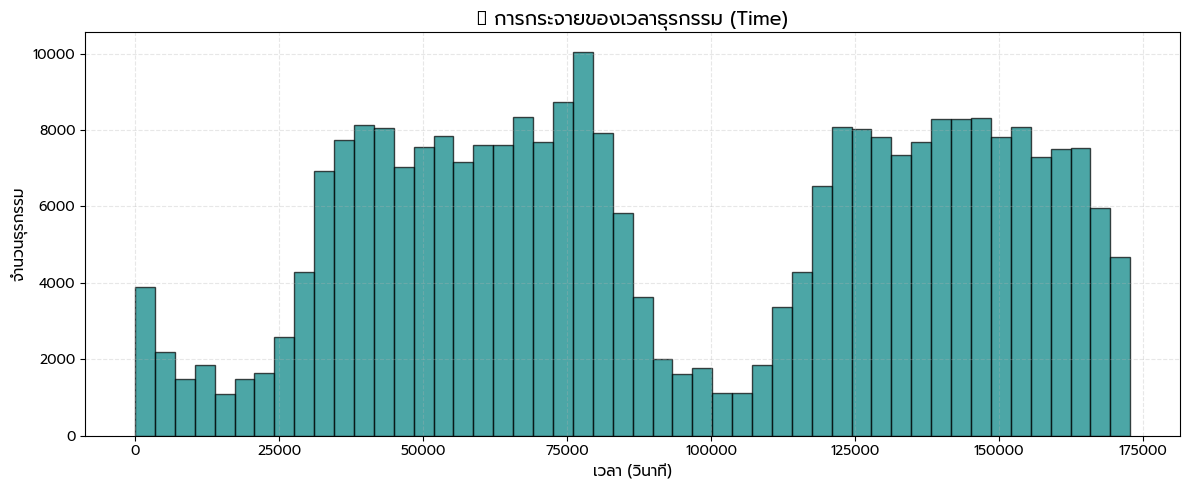

💡 สังเกต: ธุรกรรมกระจายตลอด 2 วัน (~172,800 วินาที)


In [5]:
# การกระจายของ Time (เวลาที่ทำธุรกรรม)
plt.figure(figsize=(12, 5))
df['Time'].hist(bins=50, edgecolor='black', alpha=0.7, color='teal')
plt.title('📊 การกระจายของเวลาธุรกรรม (Time)', fontsize=14, fontweight='bold')
plt.xlabel('เวลา (วินาที)', fontsize=11)
plt.ylabel('จำนวนธุรกรรม', fontsize=11)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print("💡 สังเกต: ธุรกรรมกระจายตลอด 2 วัน (~172,800 วินาที)")

📊 จำนวนธุรกรรม:
   • Normal (Class 0): 284,315 ธุรกรรม (99.83%)
   • Fraud (การฉ้อโกง)  (Class 1): 492 ธุรกรรม (0.17%)

⚠️ **Highly Imbalanced!** Fraud (การฉ้อโกง)  เพียง 0.173%


C:\Users\imed-\AppData\Local\Temp\ipykernel_34844\443804282.py:17: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  plt.tight_layout()


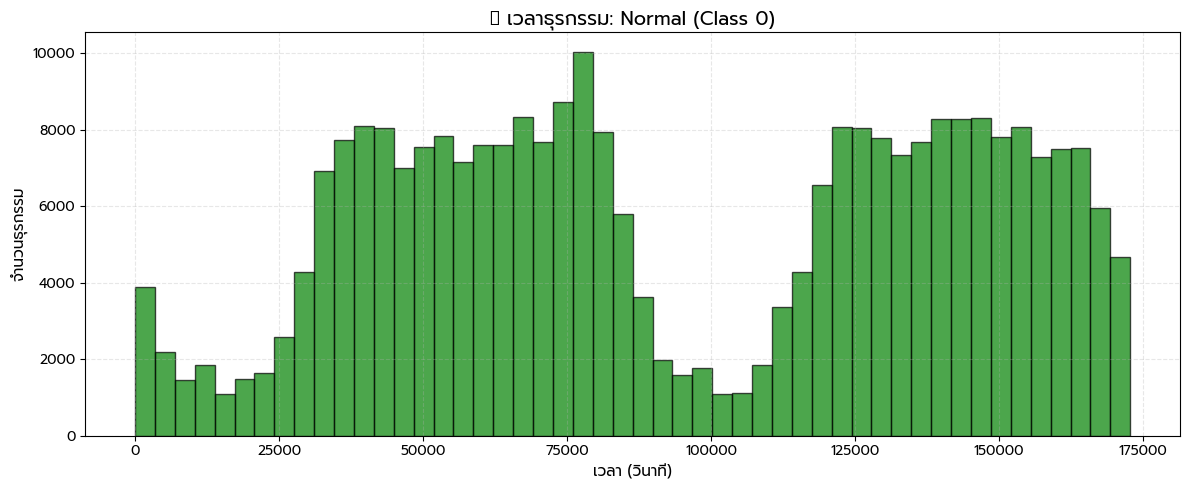

💡 Normal: กระจายทั่วทั้งวัน


In [6]:
# แยกข้อมูลตาม Class
df0 = df[df['Class'] == 0]  # Normal
df1 = df[df['Class'] == 1]  # Fraud (การฉ้อโกง) 

print(f"📊 จำนวนธุรกรรม:")
print(f"   • Normal (Class 0): {len(df0):,} ธุรกรรม ({len(df0)/len(df)*100:.2f}%)")
print(f"   • Fraud (การฉ้อโกง)  (Class 1): {len(df1):,} ธุรกรรม ({len(df1)/len(df)*100:.2f}%)")
print(f"\n⚠️ **Highly Imbalanced!** Fraud (การฉ้อโกง)  เพียง {len(df1)/len(df)*100:.3f}%")

# กราฟ Time สำหรับ Normal
plt.figure(figsize=(12, 5))
df0['Time'].hist(bins=50, edgecolor='black', alpha=0.7, color='green')
plt.title('📊 เวลาธุรกรรม: Normal (Class 0)', fontsize=14, fontweight='bold')
plt.xlabel('เวลา (วินาที)', fontsize=11)
plt.ylabel('จำนวนธุรกรรม', fontsize=11)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print("💡 Normal: กระจายทั่วทั้งวัน")

C:\Users\imed-\AppData\Local\Temp\ipykernel_34844\358627428.py:8: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  plt.tight_layout()


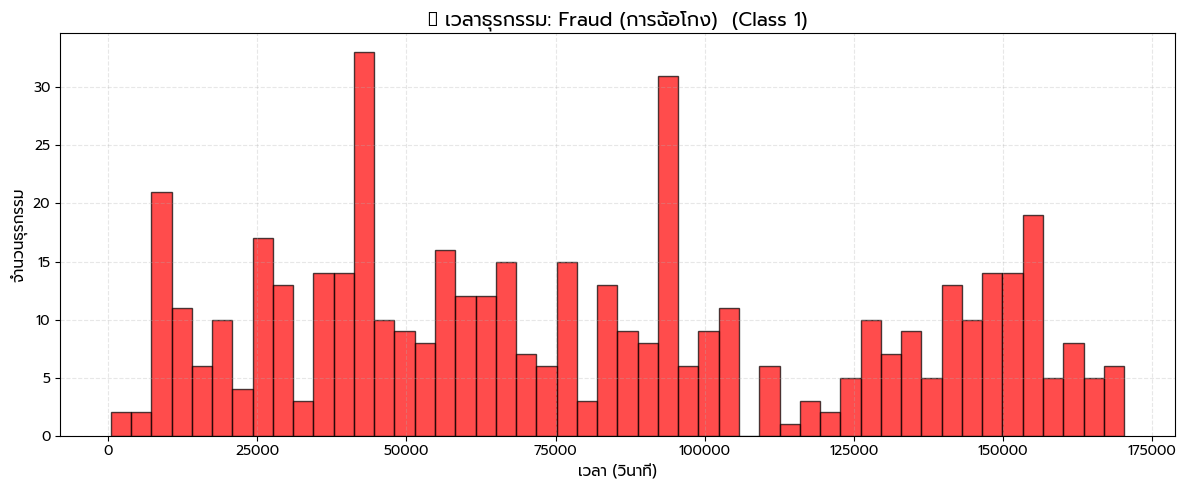

💡 Fraud (การฉ้อโกง) : มีจำนวนน้อยมาก แต่กระจายตลอดทั้งวันเช่นกัน


In [7]:
# กราฟ Time สำหรับ Fraud (การฉ้อโกง) 
plt.figure(figsize=(12, 5))
df1['Time'].hist(bins=50, edgecolor='black', alpha=0.7, color='red')
plt.title('📊 เวลาธุรกรรม: Fraud (การฉ้อโกง)  (Class 1)', fontsize=14, fontweight='bold')
plt.xlabel('เวลา (วินาที)', fontsize=11)
plt.ylabel('จำนวนธุรกรรม', fontsize=11)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print("💡 Fraud (การฉ้อโกง) : มีจำนวนน้อยมาก แต่กระจายตลอดทั้งวันเช่นกัน")

In [66]:
def plot_per_class_distributions(feature):
    """
    ฟังก์ชันเปรียบเทียบการกระจายของ feature ระหว่าง Normal และ Fraud (การฉ้อโกง) 
    
    Parameters:
    - feature: ชื่อ column ที่ต้องการวาดกราฟ
    
    คำอธิบาย:
    - 🔴 สีแดง = ธุรกรรมปกติ (Normal/NoFraud)
    - 🔵 สีน้ำเงิน = ธุรกรรมฉ้อโกง (Fraud (การฉ้อโกง) )
    - KDE (Kernel Density Estimation) = เส้นโค้งแสดงความหนาแน่นของข้อมูล
    """
    df0 = df[df['Class'] == 0]  # ธุรกรรมปกติ
    df1 = df[df['Class'] == 1]  # ธุรกรรมฉ้อโกง
    
    # สร้างกราฟ
    plt.figure(figsize=(12, 5))
    
    # วาด histogram + KDE สำหรับ Normal (สีแดง)
    sns.histplot(
        df0[feature], bins=50, color='red', kde=True,
        stat="density", linewidth=0, label='ปกติ (Normal)', alpha=0.6)
    
    # วาด histogram + KDE สำหรับ Fraud (การฉ้อโกง)  (สีน้ำเงิน)
    sns.histplot(
        df1[feature], bins=50, color='blue', kde=True,
        stat="density", linewidth=0, label='ฉ้อโกง (Fraud )', alpha=0.6)
    
    # ตกแต่งกราฟ
    plt.title(f'📊 การกระจายของ {feature}\n(เปรียบเทียบระหว่าง Normal vs Fraud (การฉ้อโกง) )', 
              fontsize=14, fontweight='bold')
    plt.xlabel(f'ค่าของ {feature}', fontsize=11)
    plt.ylabel('ความหนาแน่น (Density)', fontsize=11)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()
    
    # คำอธิบายสำหรับผู้เรียน
    print(f"💡 สังเกต: ถ้าเส้น 🔴แดง และ 🔵น้ำเงิน แยกกันชัดเจน = {feature} ช่วยแยก Fraud (การฉ้อโกง)  ได้ดี!")

## 📊 Step 4: Compare Distributions (Normal vs Fraud (การฉ้อโกง) )

### สร้างฟังก์ชันเปรียบเทียบ Distribution

**จุดประสงค์**:
- เปรียบเทียบการกระจายของแต่ละ feature ระหว่าง Normal และ Fraud (การฉ้อโกง) 
- ใช้ **Histogram + KDE** (Kernel Density Estimation)
- สี: 🔴 Red = Normal, 🔵 Blue = Fraud (การฉ้อโกง) 

C:\Users\imed-\AppData\Local\Temp\ipykernel_34844\3004318090.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  plt.tight_layout()
d:\imed-\GitHub\Naive-Bayes\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  fig.canvas.print_figure(bytes_io, **kw)


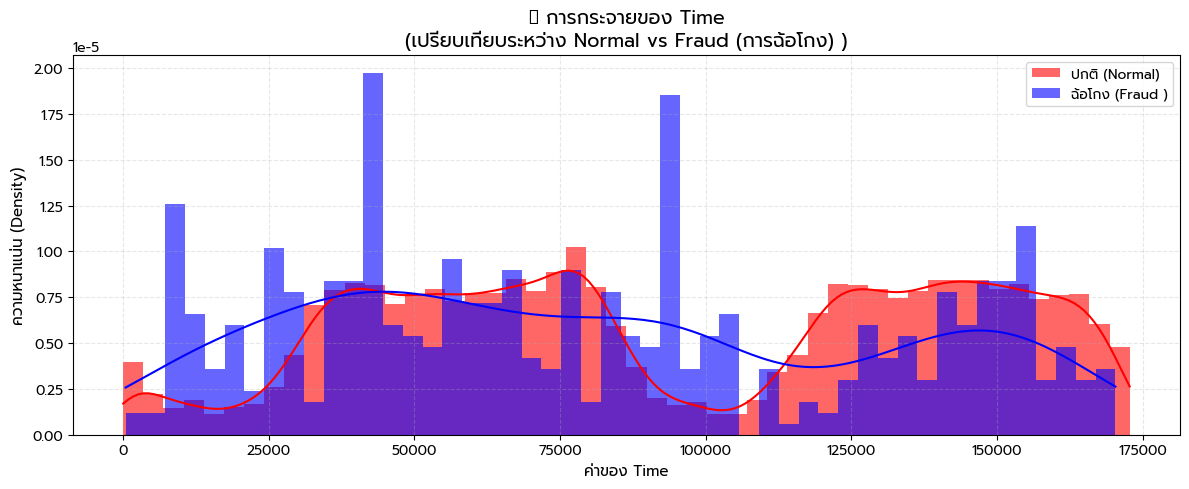

💡 สังเกต: ถ้าเส้น 🔴แดง และ 🔵น้ำเงิน แยกกันชัดเจน = Time ช่วยแยก Fraud (การฉ้อโกง)  ได้ดี!


In [67]:
plot_per_class_distributions('Time')

### 🕐 ทดสอบกับ Time

**คำถาม**: Fraud (การฉ้อโกง)  เกิดในช่วงเวลาเฉพาะหรือไม่?

C:\Users\imed-\AppData\Local\Temp\ipykernel_34844\2731328783.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  plt.tight_layout()
d:\imed-\GitHub\Naive-Bayes\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  fig.canvas.print_figure(bytes_io, **kw)


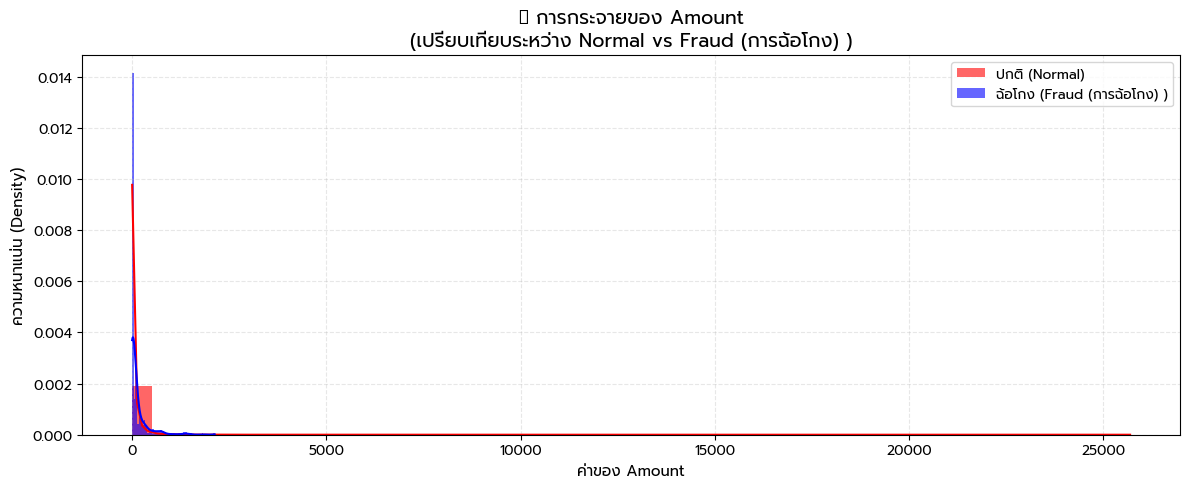

💡 สังเกต: ถ้าเส้น 🔴แดง และ 🔵น้ำเงิน แยกกันชัดเจน = Amount ช่วยแยก Fraud (การฉ้อโกง)  ได้ดี!


In [10]:
plot_per_class_distributions('Amount')

### 💰 ทดสอบกับ Amount (จำนวนเงิน)

**คำถาม**: Fraud (การฉ้อโกง)  มักใช้เงินจำนวนเท่าไหร่?

C:\Users\imed-\AppData\Local\Temp\ipykernel_34844\2731328783.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  plt.tight_layout()
d:\imed-\GitHub\Naive-Bayes\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  fig.canvas.print_figure(bytes_io, **kw)


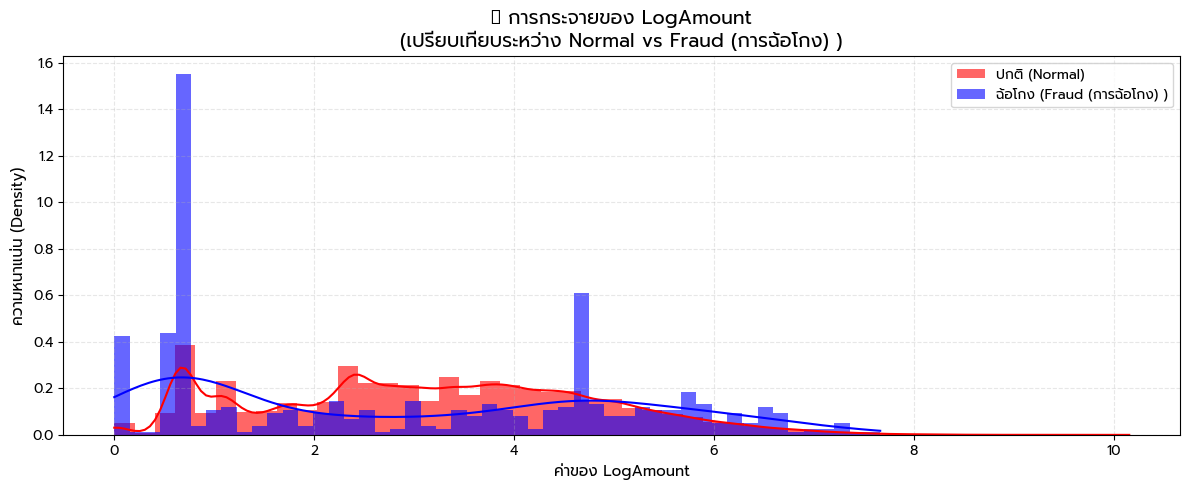

💡 สังเกต: ถ้าเส้น 🔴แดง และ 🔵น้ำเงิน แยกกันชัดเจน = LogAmount ช่วยแยก Fraud (การฉ้อโกง)  ได้ดี!


In [11]:
df['LogAmount'] = np.log1p(df['Amount'])
plot_per_class_distributions('LogAmount')

### 📈 Log Transform ของ Amount

**ทำไมต้องใช้ Log?**
- Amount มีค่าที่กระจายกว้างมาก (0 - หลายหมื่น)
- Log ช่วยทำให้การกระจายดูง่ายขึ้น
- `np.log1p()` = log(1 + x) เพื่อป้องกัน log(0) = undefined

### 🔬 ทดสอบกับ V Features (PCA Components)

**จุดประสงค์**: 
- V1-V28 คือ features จาก PCA (Principal Component Analysis)
- ข้อมูลจริงถูกซ่อนเพื่อปกป้องความเป็นส่วนตัว
- เราจะดูว่า feature ไหนช่วยแยก Fraud (การฉ้อโกง)  ได้ดี

**วิธีอ่านกราฟ**:
- ถ้าเส้น 🔴 (Normal) และ 🔵 (Fraud (การฉ้อโกง) ) **ซ้อนกัน** = feature นี้ไม่มีประโยชน์
- ถ้าเส้น 🔴 และ 🔵 **แยกกันชัดเจน** = feature นี้มีประโยชน์มาก!

💡 **ลองรัน cells ข้างล่างทีละอัน เพื่อดูการกระจายของ V1, V2, V3, ... V28**

C:\Users\imed-\AppData\Local\Temp\ipykernel_34844\2731328783.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  plt.tight_layout()
d:\imed-\GitHub\Naive-Bayes\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  fig.canvas.print_figure(bytes_io, **kw)


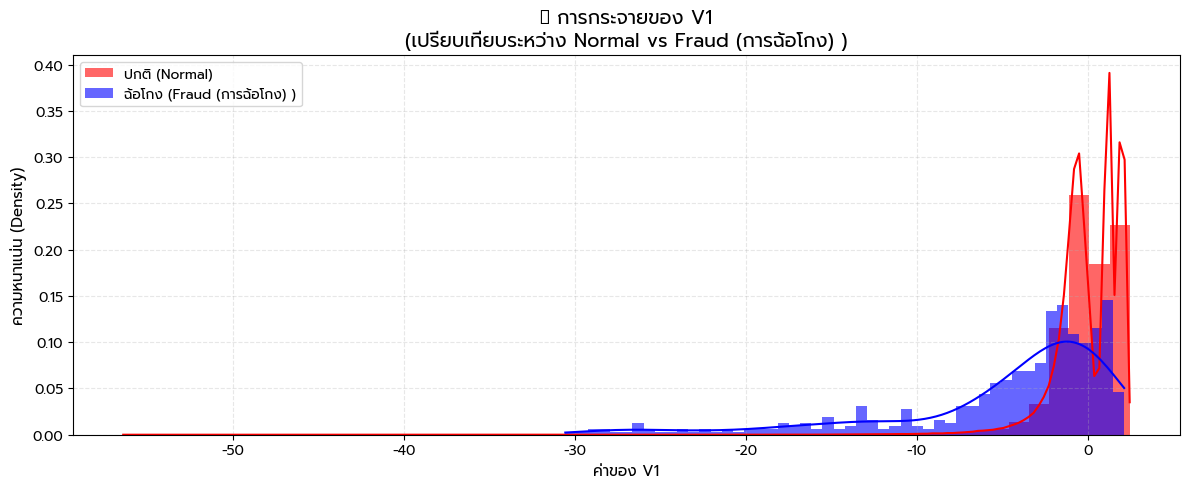

💡 สังเกต: ถ้าเส้น 🔴แดง และ 🔵น้ำเงิน แยกกันชัดเจน = V1 ช่วยแยก Fraud (การฉ้อโกง)  ได้ดี!


In [12]:
i = 1
plot_per_class_distributions(f"V{i}")

C:\Users\imed-\AppData\Local\Temp\ipykernel_34844\2731328783.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  plt.tight_layout()
d:\imed-\GitHub\Naive-Bayes\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  fig.canvas.print_figure(bytes_io, **kw)


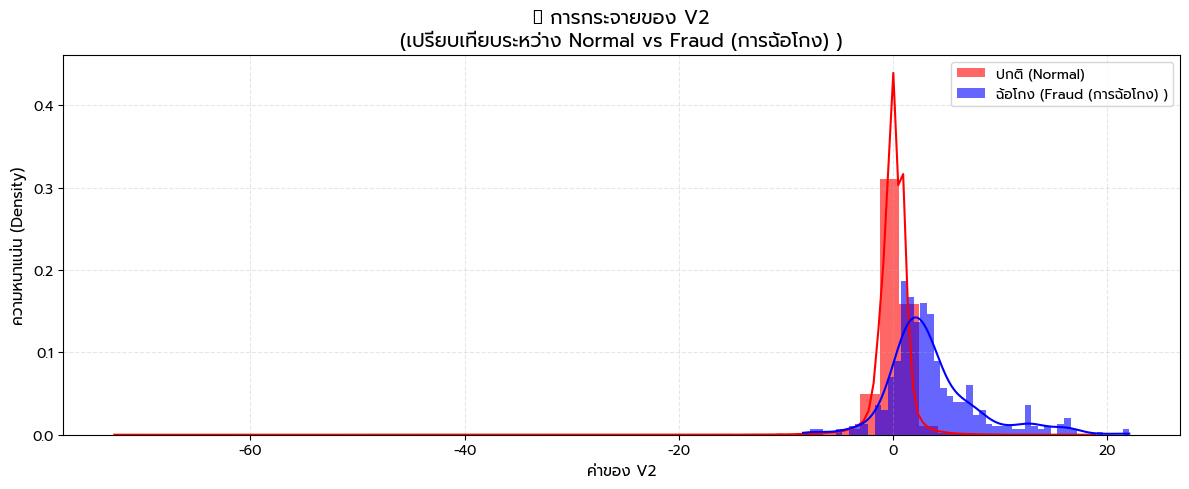

💡 สังเกต: ถ้าเส้น 🔴แดง และ 🔵น้ำเงิน แยกกันชัดเจน = V2 ช่วยแยก Fraud (การฉ้อโกง)  ได้ดี!


In [13]:
i += 1
plot_per_class_distributions(f"V{i}")

C:\Users\imed-\AppData\Local\Temp\ipykernel_34844\2731328783.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  plt.tight_layout()
d:\imed-\GitHub\Naive-Bayes\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  fig.canvas.print_figure(bytes_io, **kw)


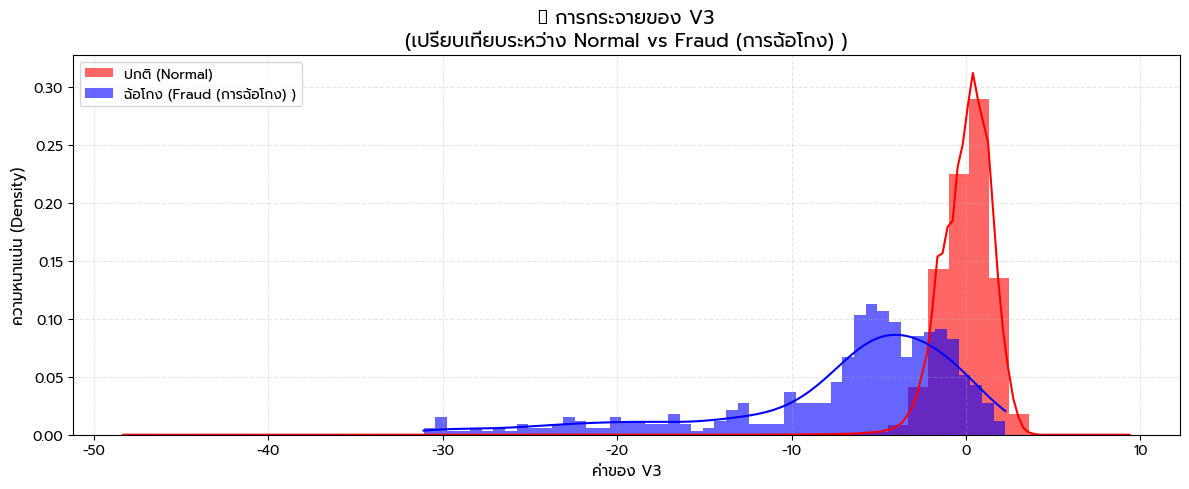

💡 สังเกต: ถ้าเส้น 🔴แดง และ 🔵น้ำเงิน แยกกันชัดเจน = V3 ช่วยแยก Fraud (การฉ้อโกง)  ได้ดี!


In [14]:
i += 1
plot_per_class_distributions(f"V{i}")

C:\Users\imed-\AppData\Local\Temp\ipykernel_34844\2731328783.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  plt.tight_layout()
d:\imed-\GitHub\Naive-Bayes\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  fig.canvas.print_figure(bytes_io, **kw)


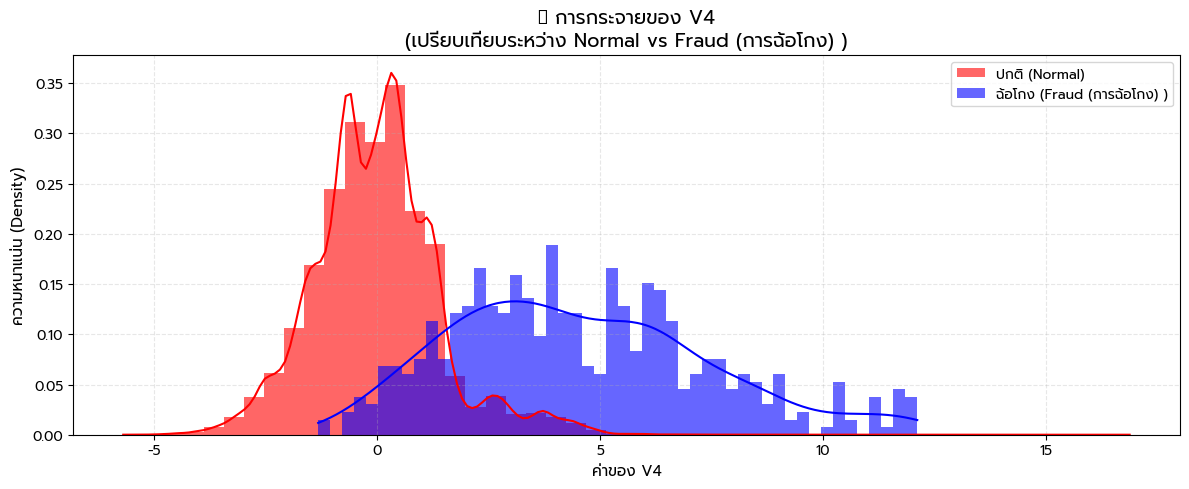

💡 สังเกต: ถ้าเส้น 🔴แดง และ 🔵น้ำเงิน แยกกันชัดเจน = V4 ช่วยแยก Fraud (การฉ้อโกง)  ได้ดี!


In [15]:
i += 1
plot_per_class_distributions(f"V{i}")

C:\Users\imed-\AppData\Local\Temp\ipykernel_34844\2731328783.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  plt.tight_layout()
d:\imed-\GitHub\Naive-Bayes\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  fig.canvas.print_figure(bytes_io, **kw)


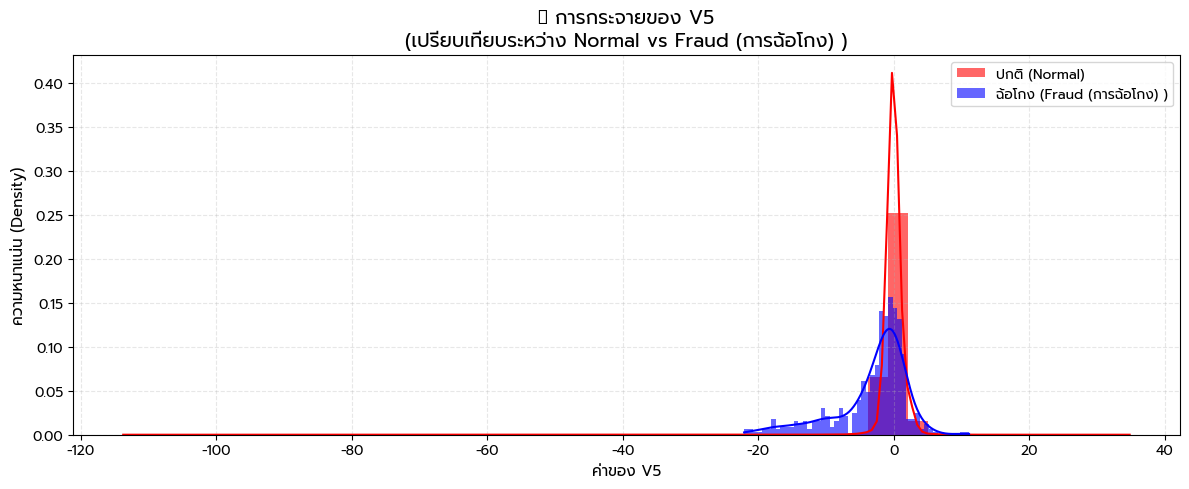

💡 สังเกต: ถ้าเส้น 🔴แดง และ 🔵น้ำเงิน แยกกันชัดเจน = V5 ช่วยแยก Fraud (การฉ้อโกง)  ได้ดี!


In [16]:
i += 1
plot_per_class_distributions(f"V{i}")

C:\Users\imed-\AppData\Local\Temp\ipykernel_34844\2731328783.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  plt.tight_layout()
d:\imed-\GitHub\Naive-Bayes\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  fig.canvas.print_figure(bytes_io, **kw)


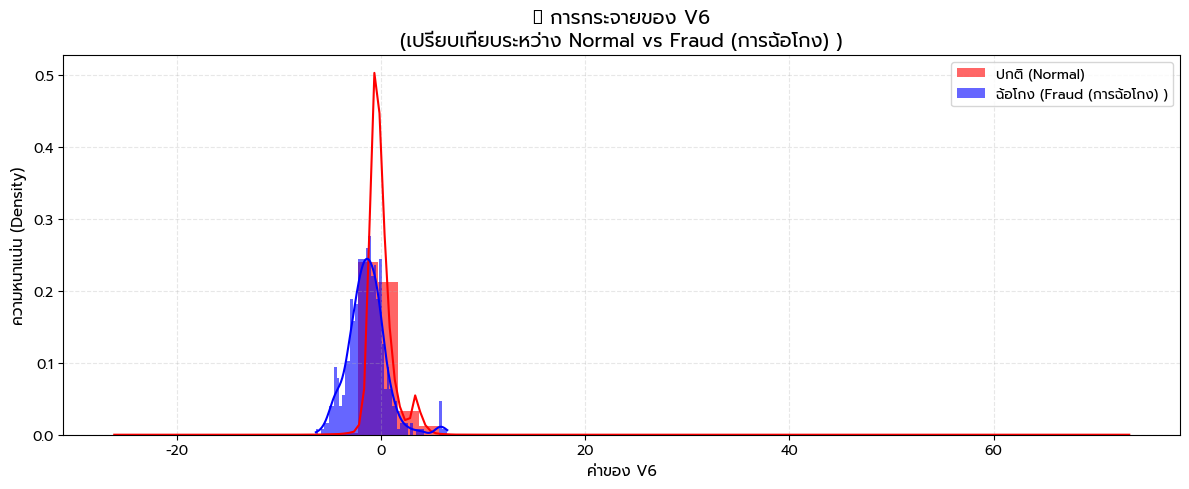

💡 สังเกต: ถ้าเส้น 🔴แดง และ 🔵น้ำเงิน แยกกันชัดเจน = V6 ช่วยแยก Fraud (การฉ้อโกง)  ได้ดี!


In [17]:
i += 1
plot_per_class_distributions(f"V{i}")

C:\Users\imed-\AppData\Local\Temp\ipykernel_34844\2731328783.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  plt.tight_layout()
d:\imed-\GitHub\Naive-Bayes\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  fig.canvas.print_figure(bytes_io, **kw)


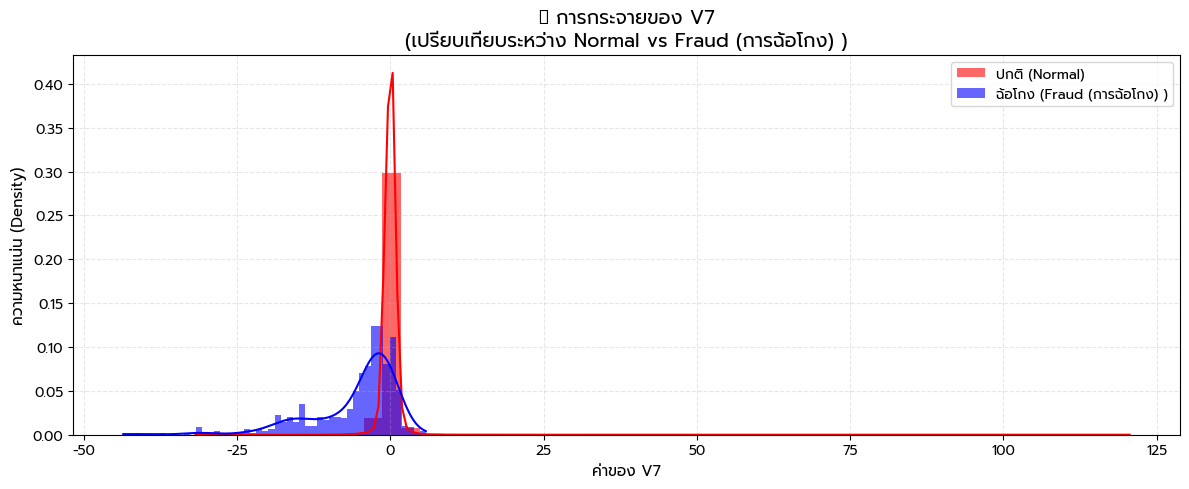

💡 สังเกต: ถ้าเส้น 🔴แดง และ 🔵น้ำเงิน แยกกันชัดเจน = V7 ช่วยแยก Fraud (การฉ้อโกง)  ได้ดี!


In [18]:
i += 1
plot_per_class_distributions(f"V{i}")

C:\Users\imed-\AppData\Local\Temp\ipykernel_34844\2731328783.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  plt.tight_layout()
d:\imed-\GitHub\Naive-Bayes\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  fig.canvas.print_figure(bytes_io, **kw)


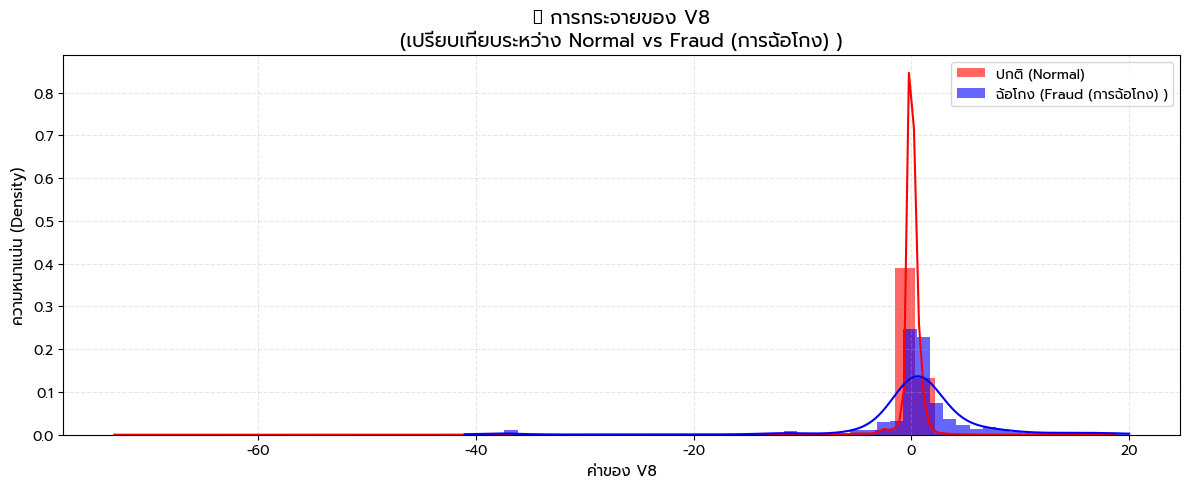

💡 สังเกต: ถ้าเส้น 🔴แดง และ 🔵น้ำเงิน แยกกันชัดเจน = V8 ช่วยแยก Fraud (การฉ้อโกง)  ได้ดี!


In [19]:
i += 1
plot_per_class_distributions(f"V{i}")

C:\Users\imed-\AppData\Local\Temp\ipykernel_34844\2731328783.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  plt.tight_layout()
d:\imed-\GitHub\Naive-Bayes\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  fig.canvas.print_figure(bytes_io, **kw)


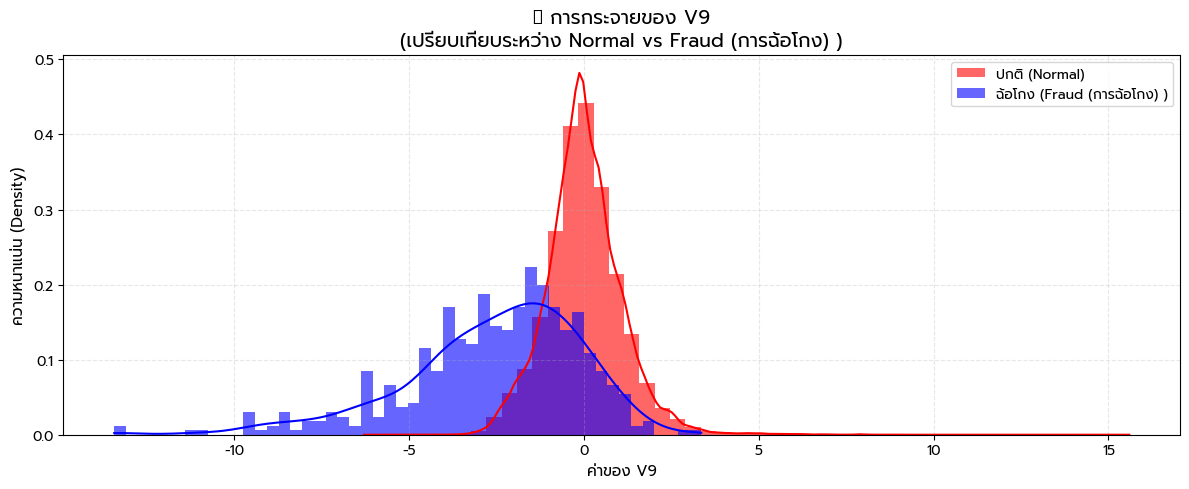

💡 สังเกต: ถ้าเส้น 🔴แดง และ 🔵น้ำเงิน แยกกันชัดเจน = V9 ช่วยแยก Fraud (การฉ้อโกง)  ได้ดี!


In [20]:
i += 1
plot_per_class_distributions(f"V{i}")

C:\Users\imed-\AppData\Local\Temp\ipykernel_34844\2731328783.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  plt.tight_layout()
d:\imed-\GitHub\Naive-Bayes\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  fig.canvas.print_figure(bytes_io, **kw)


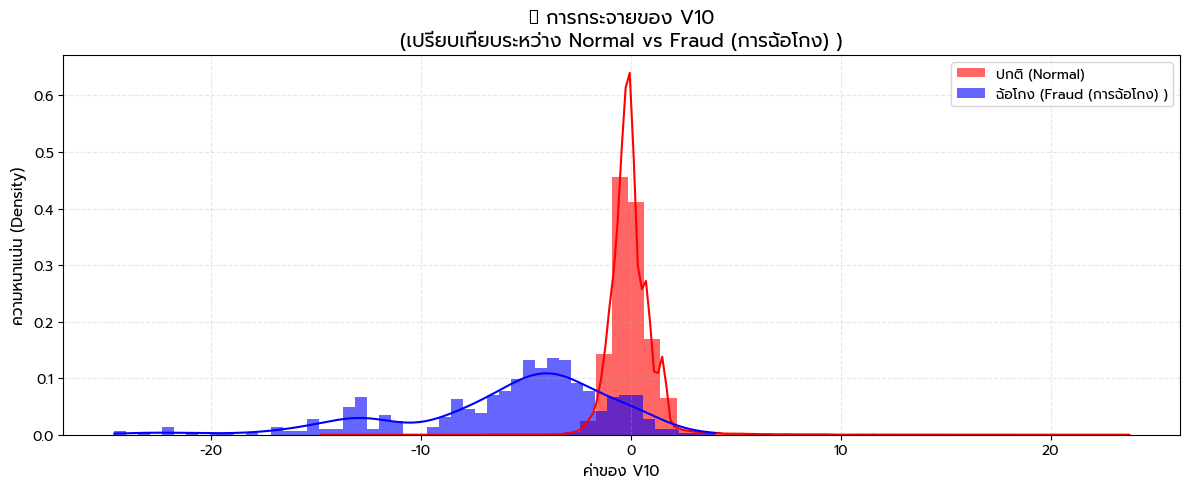

💡 สังเกต: ถ้าเส้น 🔴แดง และ 🔵น้ำเงิน แยกกันชัดเจน = V10 ช่วยแยก Fraud (การฉ้อโกง)  ได้ดี!


In [21]:
i += 1
plot_per_class_distributions(f"V{i}")

C:\Users\imed-\AppData\Local\Temp\ipykernel_34844\2731328783.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  plt.tight_layout()
d:\imed-\GitHub\Naive-Bayes\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  fig.canvas.print_figure(bytes_io, **kw)


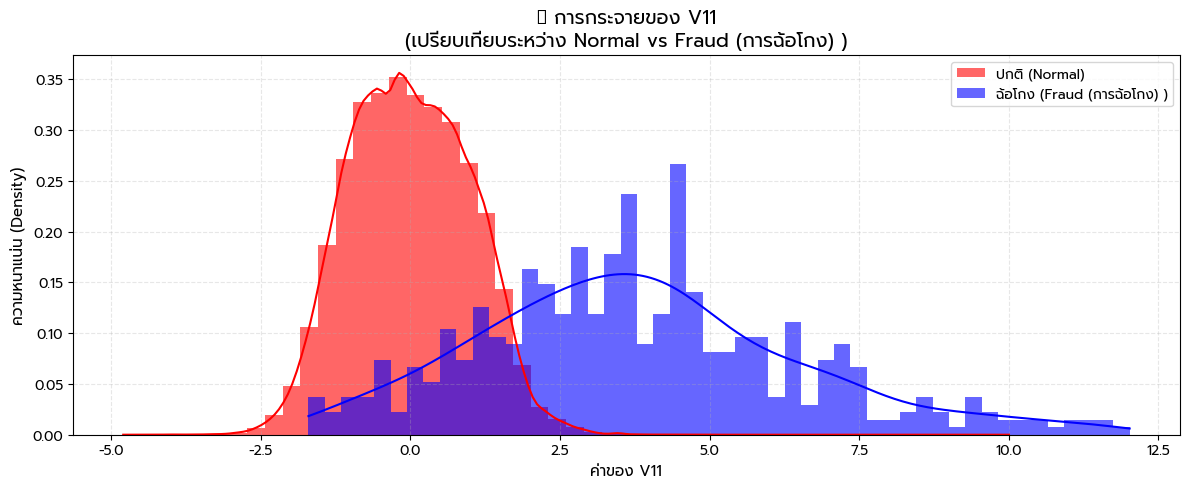

💡 สังเกต: ถ้าเส้น 🔴แดง และ 🔵น้ำเงิน แยกกันชัดเจน = V11 ช่วยแยก Fraud (การฉ้อโกง)  ได้ดี!


In [22]:
i += 1
plot_per_class_distributions(f"V{i}")

C:\Users\imed-\AppData\Local\Temp\ipykernel_34844\2731328783.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  plt.tight_layout()
d:\imed-\GitHub\Naive-Bayes\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  fig.canvas.print_figure(bytes_io, **kw)


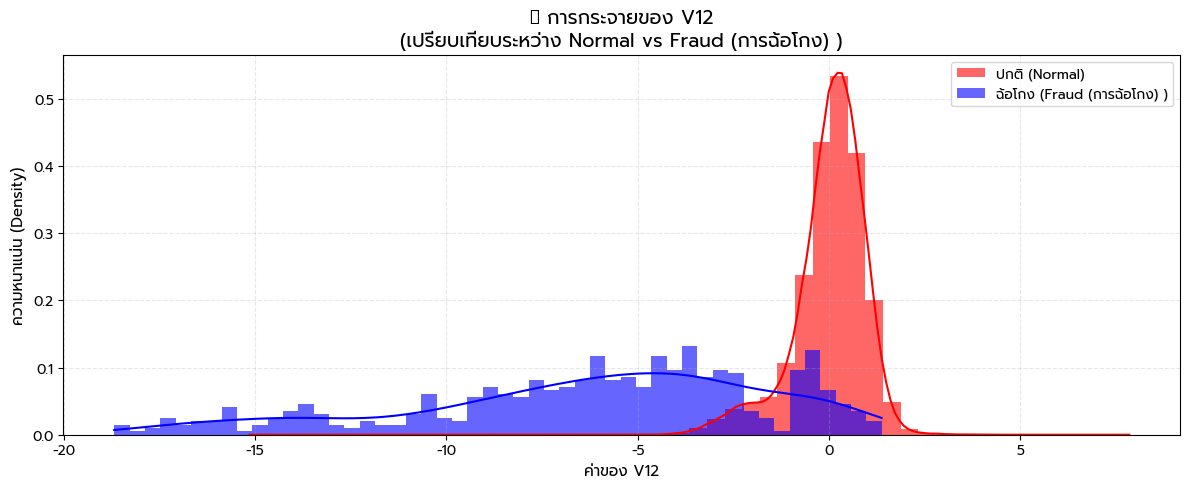

💡 สังเกต: ถ้าเส้น 🔴แดง และ 🔵น้ำเงิน แยกกันชัดเจน = V12 ช่วยแยก Fraud (การฉ้อโกง)  ได้ดี!


In [23]:
i += 1
plot_per_class_distributions(f"V{i}")

C:\Users\imed-\AppData\Local\Temp\ipykernel_34844\2731328783.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  plt.tight_layout()
d:\imed-\GitHub\Naive-Bayes\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  fig.canvas.print_figure(bytes_io, **kw)


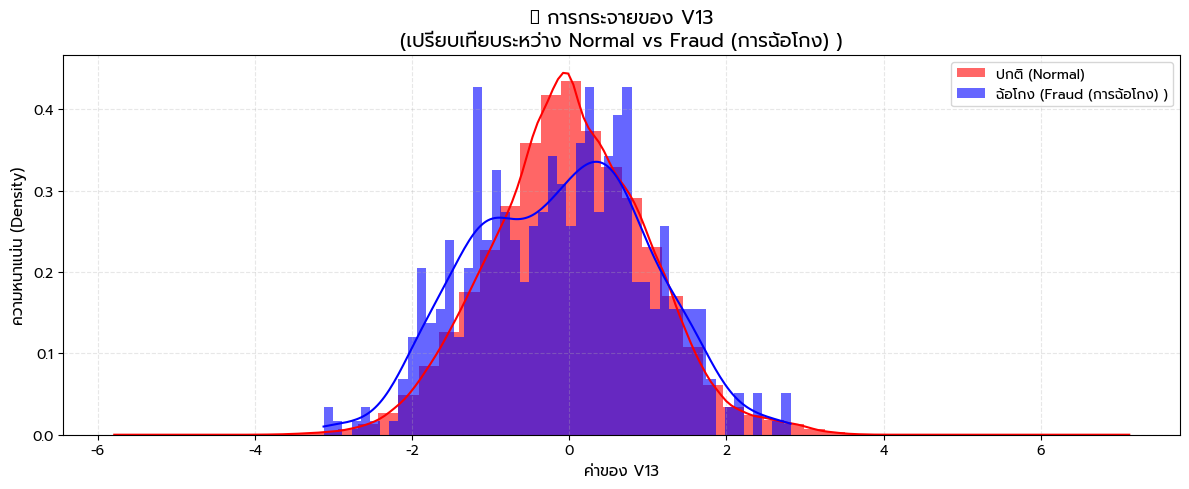

💡 สังเกต: ถ้าเส้น 🔴แดง และ 🔵น้ำเงิน แยกกันชัดเจน = V13 ช่วยแยก Fraud (การฉ้อโกง)  ได้ดี!


In [24]:
i += 1
plot_per_class_distributions(f"V{i}")

C:\Users\imed-\AppData\Local\Temp\ipykernel_34844\2731328783.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  plt.tight_layout()
d:\imed-\GitHub\Naive-Bayes\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  fig.canvas.print_figure(bytes_io, **kw)


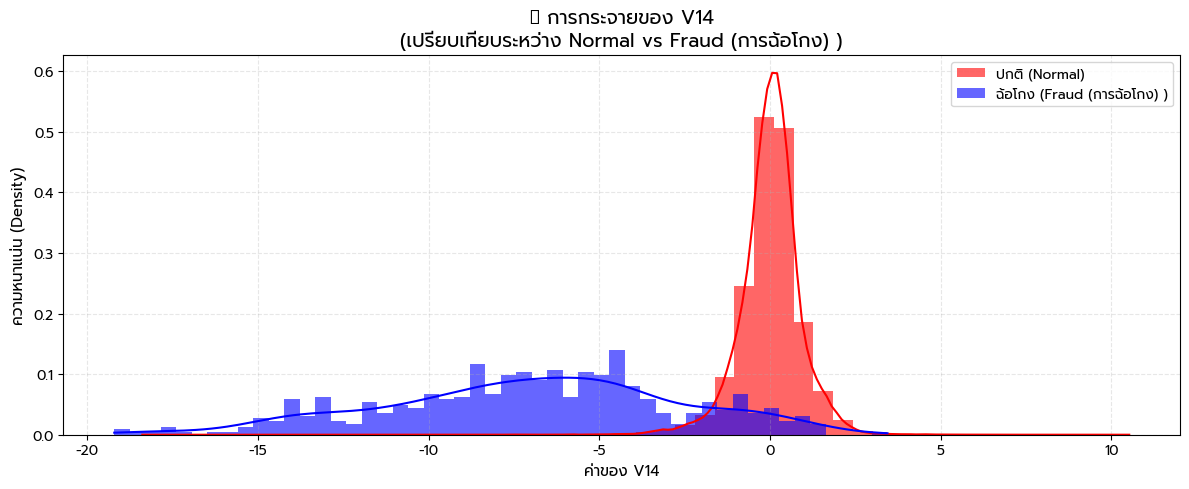

💡 สังเกต: ถ้าเส้น 🔴แดง และ 🔵น้ำเงิน แยกกันชัดเจน = V14 ช่วยแยก Fraud (การฉ้อโกง)  ได้ดี!


In [25]:
i += 1
plot_per_class_distributions(f"V{i}")

C:\Users\imed-\AppData\Local\Temp\ipykernel_34844\2731328783.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  plt.tight_layout()
d:\imed-\GitHub\Naive-Bayes\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  fig.canvas.print_figure(bytes_io, **kw)


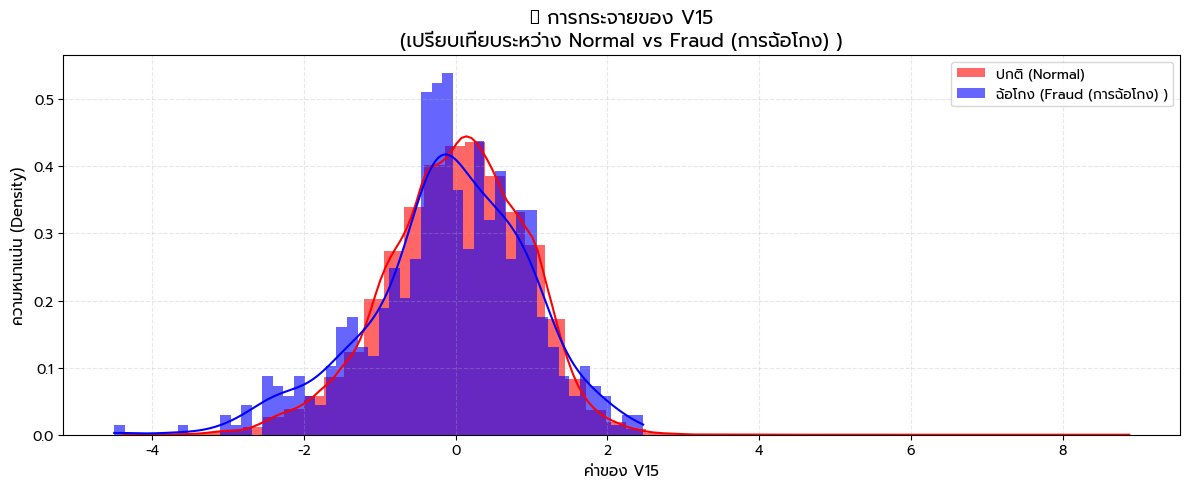

💡 สังเกต: ถ้าเส้น 🔴แดง และ 🔵น้ำเงิน แยกกันชัดเจน = V15 ช่วยแยก Fraud (การฉ้อโกง)  ได้ดี!


In [26]:
i += 1
plot_per_class_distributions(f"V{i}")

C:\Users\imed-\AppData\Local\Temp\ipykernel_34844\2731328783.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  plt.tight_layout()
d:\imed-\GitHub\Naive-Bayes\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  fig.canvas.print_figure(bytes_io, **kw)


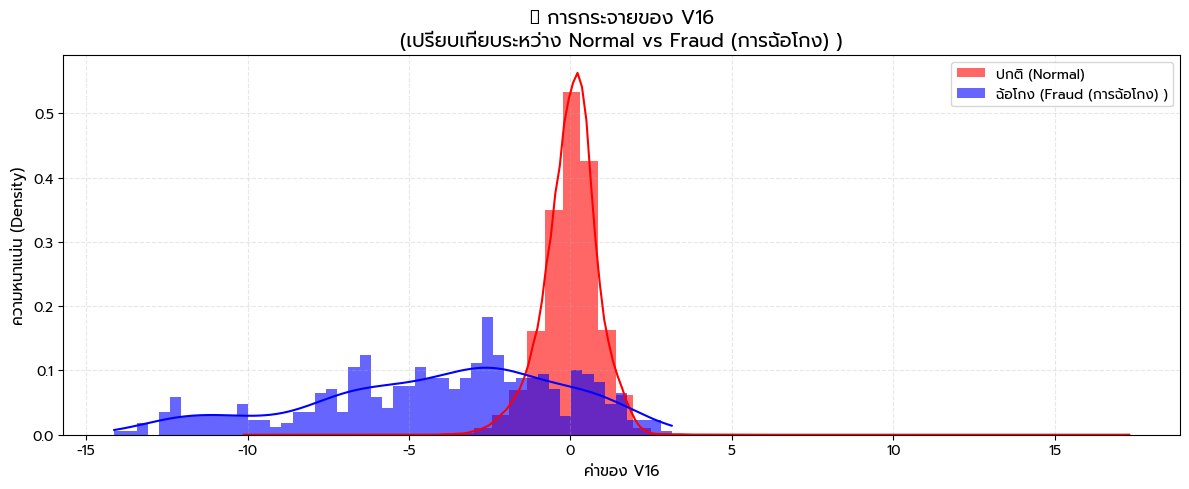

💡 สังเกต: ถ้าเส้น 🔴แดง และ 🔵น้ำเงิน แยกกันชัดเจน = V16 ช่วยแยก Fraud (การฉ้อโกง)  ได้ดี!


In [27]:
i += 1
plot_per_class_distributions(f"V{i}")

C:\Users\imed-\AppData\Local\Temp\ipykernel_34844\2731328783.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  plt.tight_layout()
d:\imed-\GitHub\Naive-Bayes\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  fig.canvas.print_figure(bytes_io, **kw)


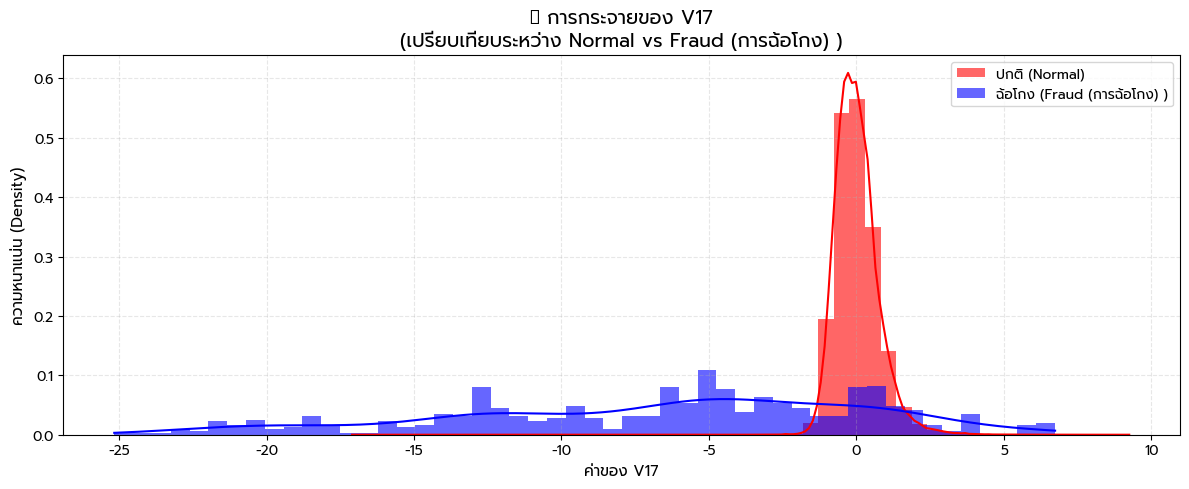

💡 สังเกต: ถ้าเส้น 🔴แดง และ 🔵น้ำเงิน แยกกันชัดเจน = V17 ช่วยแยก Fraud (การฉ้อโกง)  ได้ดี!


In [28]:
i += 1
plot_per_class_distributions(f"V{i}")

C:\Users\imed-\AppData\Local\Temp\ipykernel_34844\2731328783.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  plt.tight_layout()
d:\imed-\GitHub\Naive-Bayes\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  fig.canvas.print_figure(bytes_io, **kw)


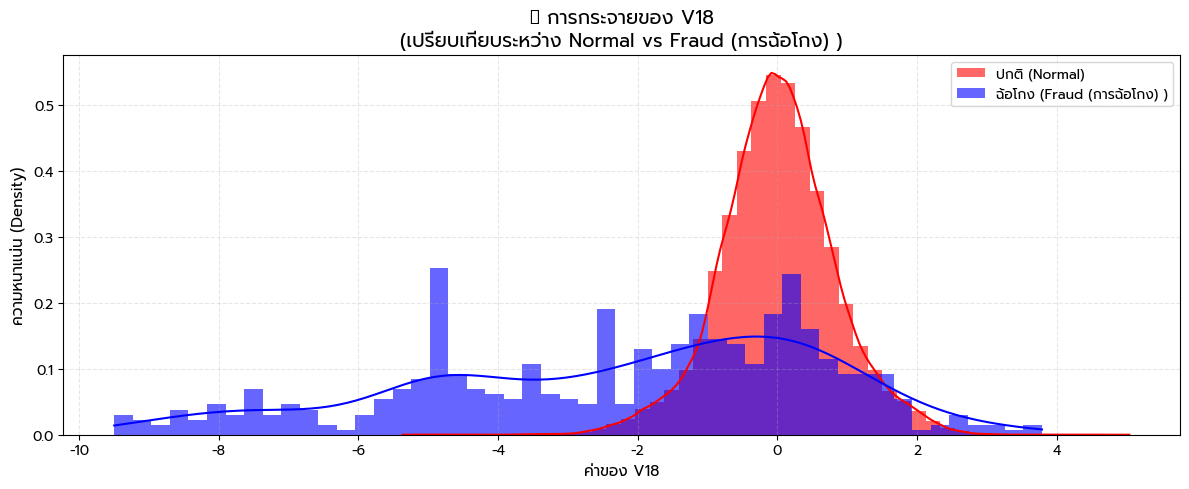

💡 สังเกต: ถ้าเส้น 🔴แดง และ 🔵น้ำเงิน แยกกันชัดเจน = V18 ช่วยแยก Fraud (การฉ้อโกง)  ได้ดี!


In [29]:
i += 1
plot_per_class_distributions(f"V{i}")

C:\Users\imed-\AppData\Local\Temp\ipykernel_34844\2731328783.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  plt.tight_layout()
d:\imed-\GitHub\Naive-Bayes\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  fig.canvas.print_figure(bytes_io, **kw)


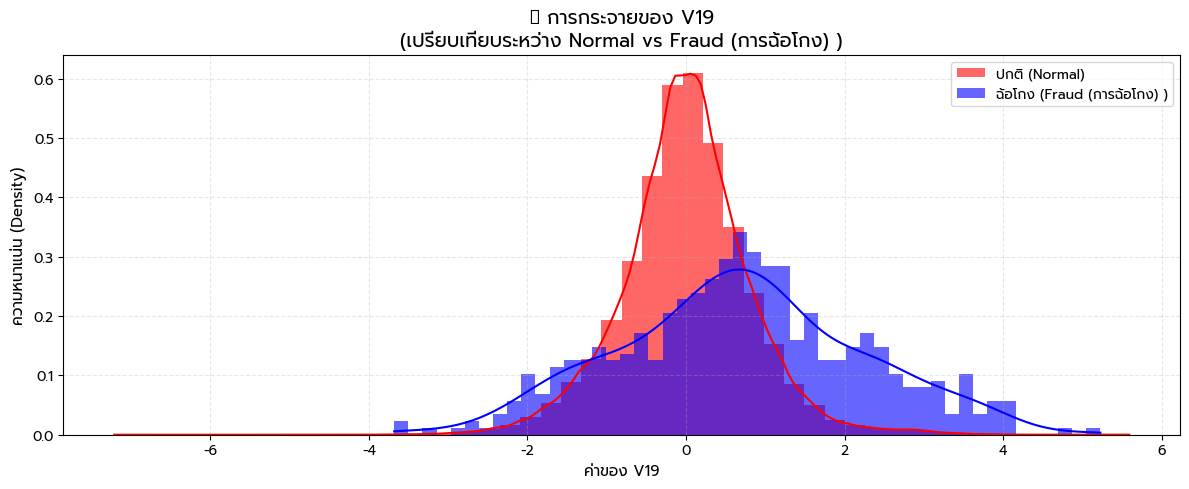

💡 สังเกต: ถ้าเส้น 🔴แดง และ 🔵น้ำเงิน แยกกันชัดเจน = V19 ช่วยแยก Fraud (การฉ้อโกง)  ได้ดี!


In [30]:
i += 1
plot_per_class_distributions(f"V{i}")

C:\Users\imed-\AppData\Local\Temp\ipykernel_34844\2731328783.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  plt.tight_layout()
d:\imed-\GitHub\Naive-Bayes\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  fig.canvas.print_figure(bytes_io, **kw)


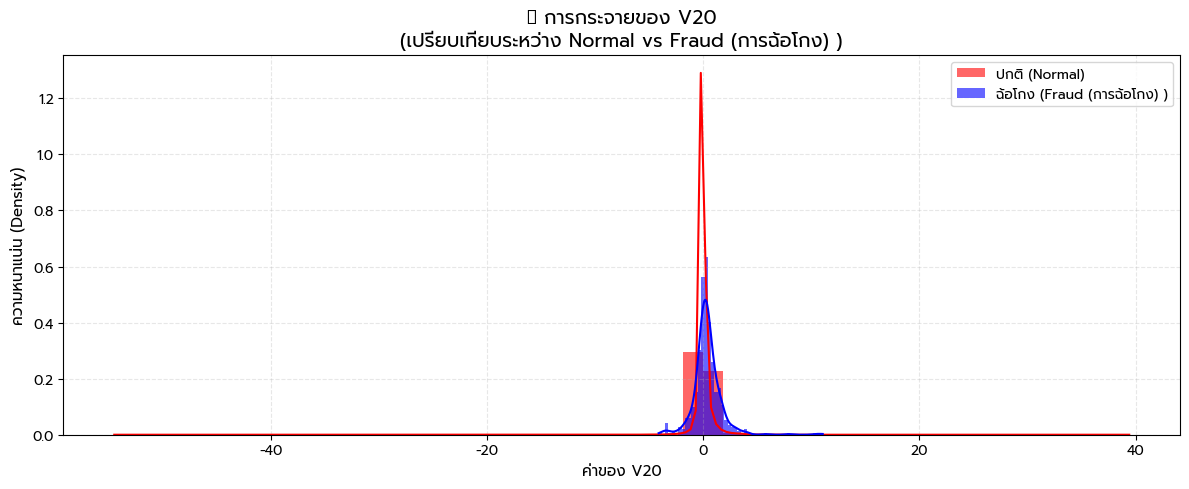

💡 สังเกต: ถ้าเส้น 🔴แดง และ 🔵น้ำเงิน แยกกันชัดเจน = V20 ช่วยแยก Fraud (การฉ้อโกง)  ได้ดี!


In [31]:
i += 1
plot_per_class_distributions(f"V{i}")

C:\Users\imed-\AppData\Local\Temp\ipykernel_34844\2731328783.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  plt.tight_layout()
d:\imed-\GitHub\Naive-Bayes\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  fig.canvas.print_figure(bytes_io, **kw)


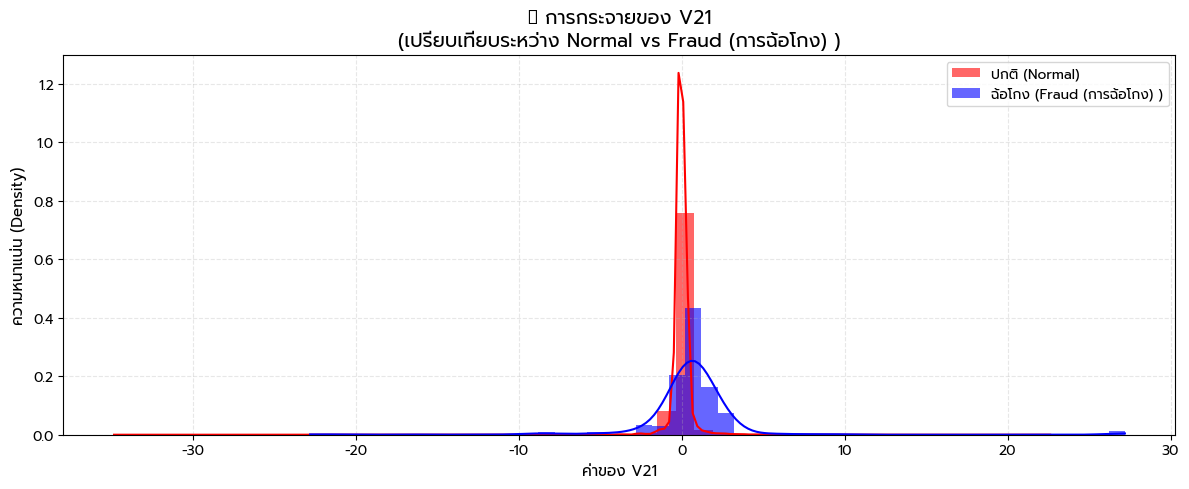

💡 สังเกต: ถ้าเส้น 🔴แดง และ 🔵น้ำเงิน แยกกันชัดเจน = V21 ช่วยแยก Fraud (การฉ้อโกง)  ได้ดี!


In [32]:
i += 1
plot_per_class_distributions(f"V{i}")

C:\Users\imed-\AppData\Local\Temp\ipykernel_34844\2731328783.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  plt.tight_layout()
d:\imed-\GitHub\Naive-Bayes\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  fig.canvas.print_figure(bytes_io, **kw)
d:\imed-\GitHub\Naive-Bayes\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  fig.canvas.print_figure(bytes_io, **kw)


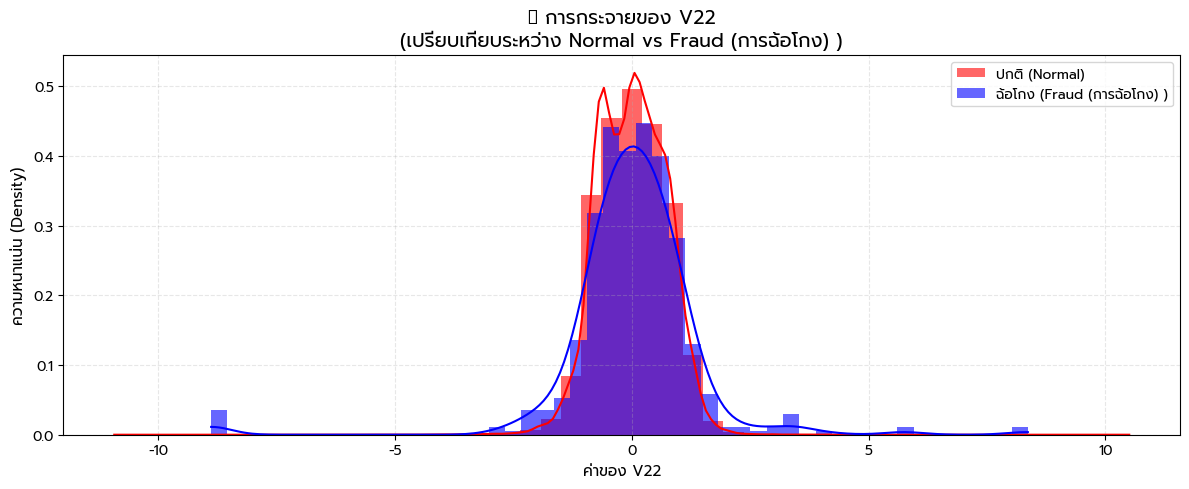

💡 สังเกต: ถ้าเส้น 🔴แดง และ 🔵น้ำเงิน แยกกันชัดเจน = V22 ช่วยแยก Fraud (การฉ้อโกง)  ได้ดี!


In [33]:
i += 1
plot_per_class_distributions(f"V{i}")

C:\Users\imed-\AppData\Local\Temp\ipykernel_34844\2731328783.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  plt.tight_layout()
d:\imed-\GitHub\Naive-Bayes\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  fig.canvas.print_figure(bytes_io, **kw)


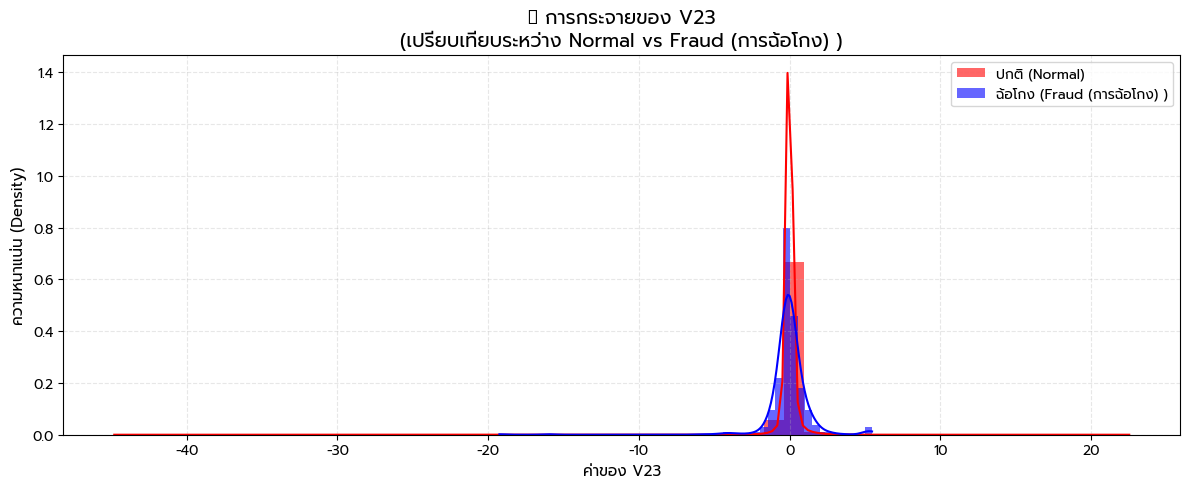

💡 สังเกต: ถ้าเส้น 🔴แดง และ 🔵น้ำเงิน แยกกันชัดเจน = V23 ช่วยแยก Fraud (การฉ้อโกง)  ได้ดี!


In [34]:
i += 1
plot_per_class_distributions(f"V{i}")

C:\Users\imed-\AppData\Local\Temp\ipykernel_34844\2731328783.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  plt.tight_layout()
d:\imed-\GitHub\Naive-Bayes\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  fig.canvas.print_figure(bytes_io, **kw)


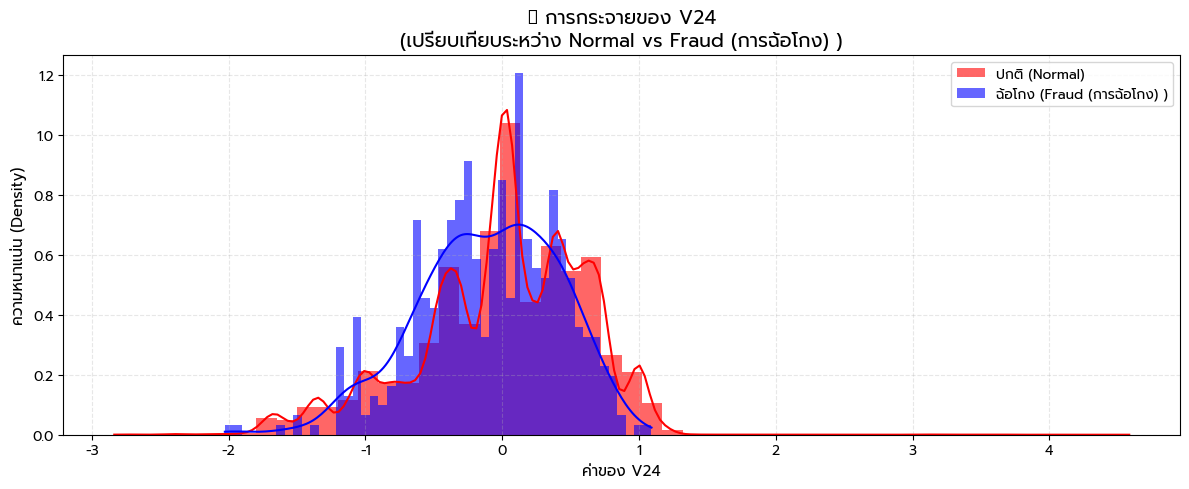

💡 สังเกต: ถ้าเส้น 🔴แดง และ 🔵น้ำเงิน แยกกันชัดเจน = V24 ช่วยแยก Fraud (การฉ้อโกง)  ได้ดี!


In [35]:
i += 1
plot_per_class_distributions(f"V{i}")

C:\Users\imed-\AppData\Local\Temp\ipykernel_34844\2731328783.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  plt.tight_layout()
d:\imed-\GitHub\Naive-Bayes\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  fig.canvas.print_figure(bytes_io, **kw)


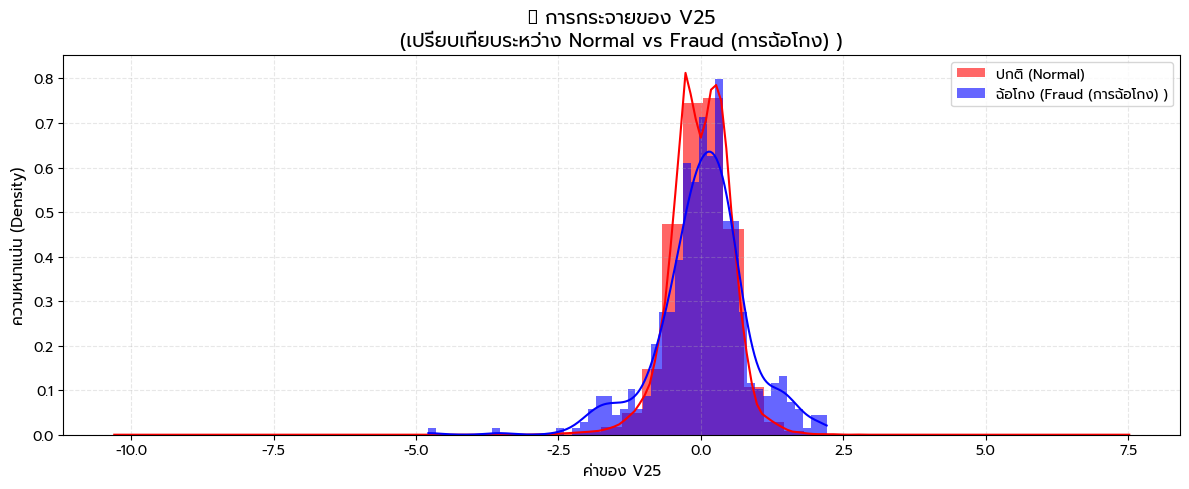

💡 สังเกต: ถ้าเส้น 🔴แดง และ 🔵น้ำเงิน แยกกันชัดเจน = V25 ช่วยแยก Fraud (การฉ้อโกง)  ได้ดี!


In [36]:
i += 1
plot_per_class_distributions(f"V{i}")

C:\Users\imed-\AppData\Local\Temp\ipykernel_34844\2731328783.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  plt.tight_layout()
d:\imed-\GitHub\Naive-Bayes\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  fig.canvas.print_figure(bytes_io, **kw)


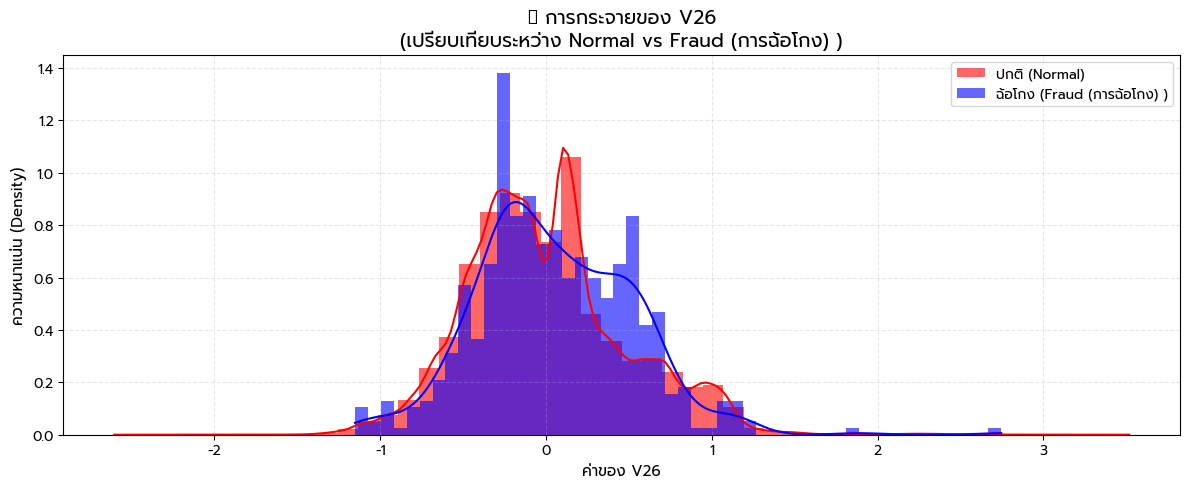

💡 สังเกต: ถ้าเส้น 🔴แดง และ 🔵น้ำเงิน แยกกันชัดเจน = V26 ช่วยแยก Fraud (การฉ้อโกง)  ได้ดี!


In [37]:
i += 1
plot_per_class_distributions(f"V{i}")

C:\Users\imed-\AppData\Local\Temp\ipykernel_34844\2731328783.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  plt.tight_layout()
d:\imed-\GitHub\Naive-Bayes\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  fig.canvas.print_figure(bytes_io, **kw)


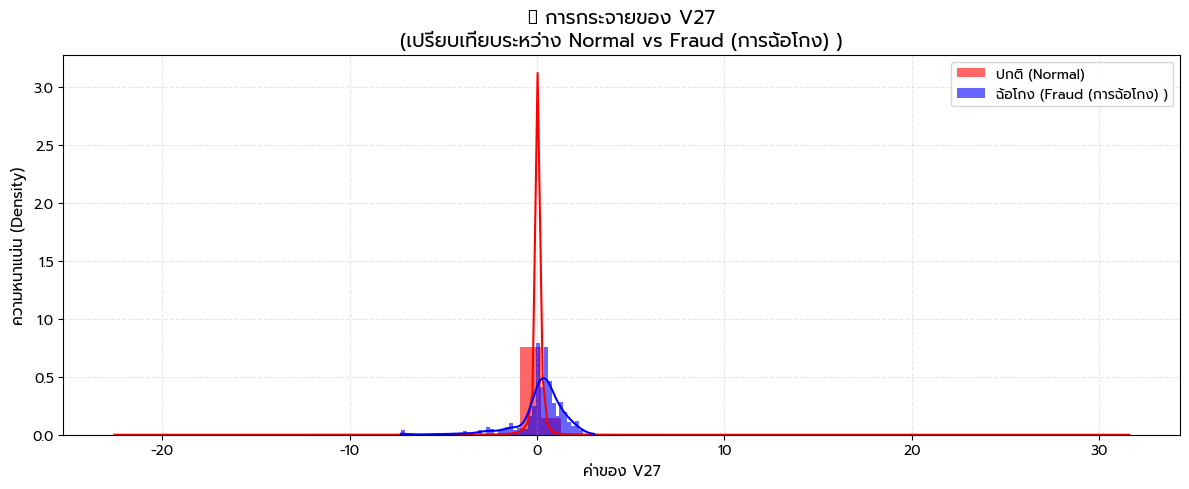

💡 สังเกต: ถ้าเส้น 🔴แดง และ 🔵น้ำเงิน แยกกันชัดเจน = V27 ช่วยแยก Fraud (การฉ้อโกง)  ได้ดี!


In [38]:
i += 1
plot_per_class_distributions(f"V{i}")

C:\Users\imed-\AppData\Local\Temp\ipykernel_34844\2731328783.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  plt.tight_layout()
d:\imed-\GitHub\Naive-Bayes\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  fig.canvas.print_figure(bytes_io, **kw)


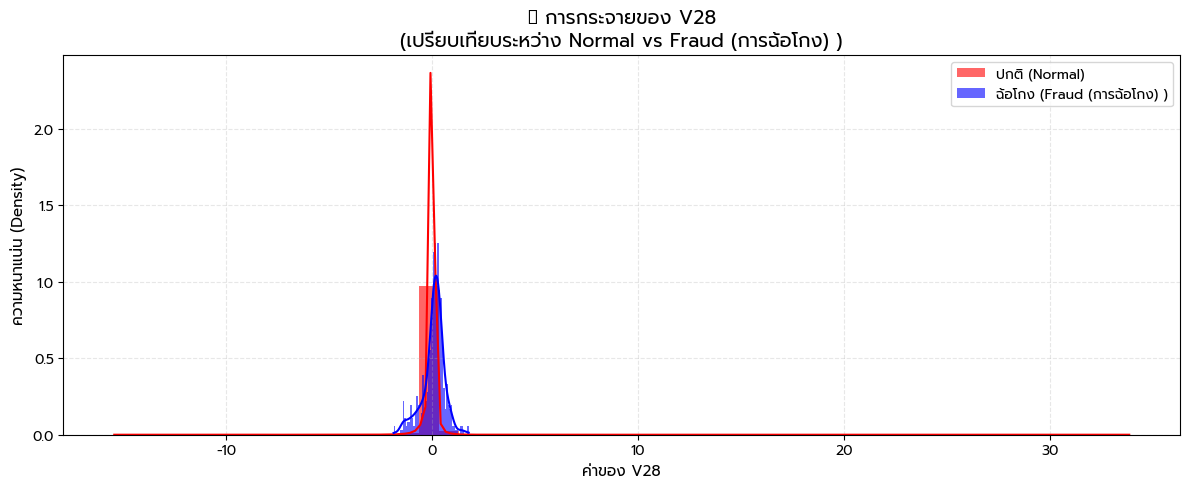

💡 สังเกต: ถ้าเส้น 🔴แดง และ 🔵น้ำเงิน แยกกันชัดเจน = V28 ช่วยแยก Fraud (การฉ้อโกง)  ได้ดี!


In [39]:
i += 1
plot_per_class_distributions(f"V{i}")

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

---

## 🏋️ Step 5: Train Gaussian Naive Bayes Model

### 📚 ทฤษฎีพื้นฐาน: Gaussian Naive Bayes คืออะไร?

**Naive Bayes** ทำงานโดยคำนวณความน่าจะเป็น:
- P(Fraud (การฉ้อโกง)  | Features) = โอกาสที่เป็น Fraud (การฉ้อโกง)  เมื่อเห็น Features นี้
- ใช้ **Bayes' Theorem**: P(A|B) = P(B|A) × P(A) / P(B)

**Gaussian NB** สมมติว่า:
- แต่ละ feature มีการกระจายแบบ **Normal Distribution** (ระฆังคว่ำ)
- Features **เป็นอิสระ** ต่อกันแยก (Naive Assumption)

**ทำไมเหมาะกับข้อมูลนี้?**
- V1-V28 เป็น continuous features (ค่าต่อเนื่อง)
- เร็ว! เหมาะกับข้อมูล 284,807 rows
- ทำงานได้ดีกับข้อมูลที่มีหลาย features

In [41]:
# DO NOT DO
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

### ⚠️ สิ่งที่ไม่ควรทำ: Random Split

**ทำไม "DO NOT DO"?**
- ข้อมูลเรียงตามเวลา (Time เรียงจากน้อย → มาก)
- Random split = ใช้อนาคตทำนายอดีต! (Data Leakage)
- ในชีวิตจริง: เราต้องทำนายธุรกรรมใหม่ที่ยังไม่เกิด

**วิธีที่ถูก**: Split ตามเวลา (เดี๋ยวจะแก้ในขั้นตอนถัดไป)

In [42]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class', 'LogAmount'],
      dtype='object')

### 📋 เช็ค Columns ทั้งหมดในข้อมูล

In [43]:
features = ['Time', 'Amount'] + [f"V{i}" for i in range(1, 29)]
print(features)

['Time', 'Amount', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']


### 🎯 เลือก Features สำหรับ Model

**Features ที่ใช้**:
- `Time`: เวลาที่ทำธุรกรรม
- `Amount`: จำนวนเงิน
- `V1` - `V28`: PCA components (28 ตัว)

รวม = **30 features**

In [44]:
X_train = df_train[features]
y_train = df_train['Class']
X_test  = df_test[features]
y_test  = df_test['Class']

### 🔪 แบ่งข้อมูลเป็น Train/Test Sets

**ตัวแปร**:
- `X_train`, `X_test`: Features (V1-V28, Time, Amount)
- `y_train`, `y_test`: Target (Class: 0=Normal, 1=Fraud (การฉ้อโกง) )

In [45]:
model = GaussianNB()
model.fit(X_train, y_train)
print("train acc:", model.score(X_train, y_train))
print("test acc:", model.score(X_test, y_test))

train acc: 0.9935175228773947
test acc: 0.9930128857835048


### 🚀 Train โมเดล + วัด Accuracy

**ขั้นตอน**:
1. `GaussianNB()`: สร้างโมเดล
2. `.fit()`: ฝึกโมเดลด้วยข้อมูล train
3. `.score()`: วัดความแม่นยำ (Accuracy)

In [46]:
(df['Class'] == 1).sum() / df.shape[0]

np.float64(0.001727485630620034)

### 📊 เช็คสัดส่วน Fraud (การฉ้อโกง)  ในข้อมูล

**ทำไมต้องเช็ค?**
- เพื่อเปรียบเทียบกับ Accuracy
- ถ้า Accuracy ≈ สัดส่วน Normal = โมเดลไม่ได้เรียนรู้อะไรเลย!
- โมเดลอาจแค่ทายว่า "ทุกอันเป็น Normal" (เพราะ 99.83% เป็น Normal)

In [47]:
from sklearn.metrics import f1_score, roc_auc_score, \
  precision_score, recall_score

---

## 🎯 Step 6: Evaluate with Better Metrics

### ⚠️ ทำไม Accuracy ไม่พอ?

เพราะข้อมูล **Highly Imbalanced** (Fraud (การฉ้อโกง)  < 0.2%)!

**ตัวอย่าง**: โมเดลโง่ที่ทายว่า "ทุกอันเป็น Normal"
- Accuracy = 99.83% (ดูดีมาก!)
- แต่จับ Fraud (การฉ้อโกง)  ได้ **0%** (ไร้ประโยชน์!)

### 📏 Metrics ที่ดีกว่า:

1. **Precision** (ความแม่นยำ):
   - จาก 100 ธุรกรรมที่เราทายว่า "Fraud (การฉ้อโกง) " → มีกี่อันที่เป็น Fraud (การฉ้อโกง)  จริง?
   - สูง = ไม่กล่าวหาลูกค้าผิด (ลด False Positive)

2. **Recall** (ความครบถ้วน):
   - จาก 100 Fraud (การฉ้อโกง)  จริง → เราจับได้กี่อัน?
   - สูง = จับ Fraud (การฉ้อโกง)  ได้เยอะ (ลด False Negative)

3. **F1-Score** (ค่ากลาง):
   - ค่าเฉลี่ยของ Precision และ Recall
   - ดีเมื่อต้องการสมดุลระหว่าง 2 ค่า

4. **AUC-ROC** (Area Under Curve):
   - วัดความสามารถแยก class โดยรวม
   - 0.5 = ทายสุ่ม, 1.0 = สมบูรณ์แบบ

In [48]:
def print_metrics(X, y, name):
  probs = model.predict_proba(X)
  print(f"{name} AUC:", roc_auc_score(y, probs[:, 1]))
  preds = model.predict(X)
  print(f"{name} precision:", precision_score(y, preds))
  print(f"{name} recall:", recall_score(y, preds))
  print(f"{name} f1:", f1_score(y, preds))

### 📊 สร้างฟังก์ชันแสดง Metrics ทั้งหมด

ฟังก์ชันนี้จะคำนวณและแสดง:
- AUC (ใช้ probability จาก `.predict_proba()`)
- Precision, Recall, F1 (ใช้ prediction จาก `.predict()`)

In [49]:
print_metrics(X_train, y_train, 'Train')

Train AUC: 0.9682271444553004
Train precision: 0.16219588271990018
Train recall: 0.6598984771573604
Train f1: 0.26039058587881825


### 📈 ผล Training Set

**วิเคราะห์**:
- AUC สูง (>0.9) = โมเดลแยก Normal/Fraud (การฉ้อโกง)  ได้ดี
- Precision/Recall ต่ำ = ยังจับ Fraud (การฉ้อโกง)  ได้ไม่ดีพอ

In [50]:
print_metrics(X_test, y_test, 'Test')

Test AUC: 0.9697767067575482
Test precision: 0.14622641509433962
Test recall: 0.6326530612244898
Test f1: 0.23754789272030652


### 📉 ผล Test Set

**เปรียบเทียบกับ Train**:
- ถ้า Test ≈ Train = ดี! (ไม่ Overfit)
- ถ้า Test << Train = Overfit (จำข้อมูล train มากเกินไป)

In [51]:
diff = df['Time'].diff()
diff

0         NaN
1         0.0
2         1.0
3         0.0
4         1.0
         ... 
284802    1.0
284803    1.0
284804    1.0
284805    0.0
284806    4.0
Name: Time, Length: 284807, dtype: float64

---

## 🕰️ Step 7: Fix Time-Based Data Leakage

### 🔍 ตรวจสอบ Time Feature

**คำถาม**: Time เป็นเวลาจริง หรือเป็นลำดับที่เรียงไว้?

In [52]:
np.all(diff.iloc[1:] >= 0) # always increasing

np.True_

### ✅ ยืนยัน: Time เรียงจากน้อย → มาก (ต่อเนื่อง)

**ความหมาย**: 
- Time = วินาทีนับจากธุรกรรมแรก
- ข้อมูลเรียงตามลำดับเวลาจริง

In [53]:
# How many days of data?
df['Time'].max() / (24 * 60 * 60)

np.float64(1.9999074074074075)

### 📅 ข้อมูลครอบคลุมกี่วัน?

คำนวณ: Time (วินาที) ÷ (24 ชม. × 60 นาที × 60 วินาที)

C:\Users\imed-\AppData\Local\Temp\ipykernel_34844\2731328783.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  plt.tight_layout()
d:\imed-\GitHub\Naive-Bayes\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Prompt.
  fig.canvas.print_figure(bytes_io, **kw)


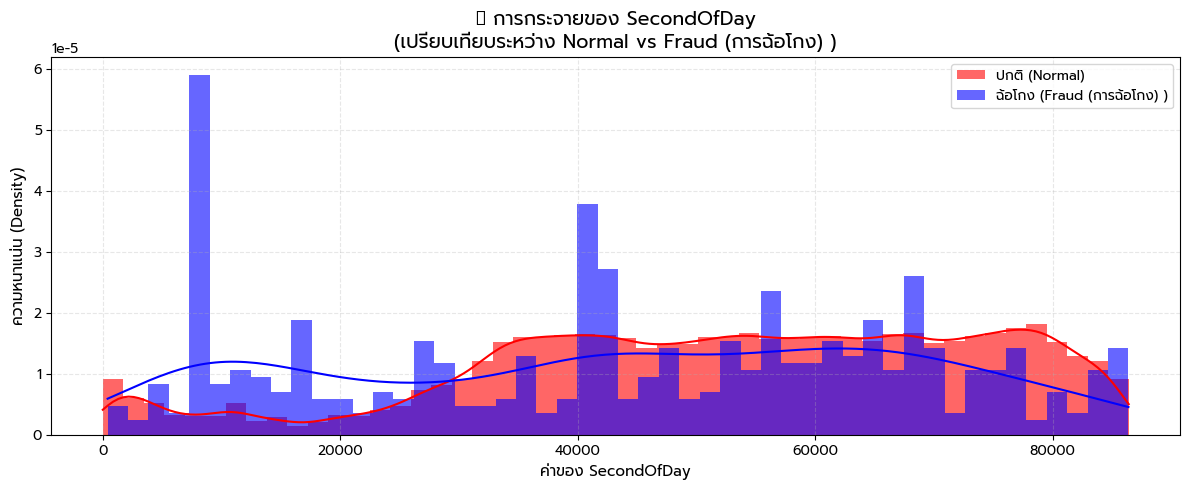

💡 สังเกต: ถ้าเส้น 🔴แดง และ 🔵น้ำเงิน แยกกันชัดเจน = SecondOfDay ช่วยแยก Fraud (การฉ้อโกง)  ได้ดี!


In [54]:
df['SecondOfDay'] = (df['Time'] % (24 * 60 * 60))
plot_per_class_distributions('SecondOfDay')

### 🔄 Feature Engineering: SecondOfDay

**ทำไมต้องสร้าง SecondOfDay?**
- Time เพิ่มเรื่อย ๆ (ไม่มีรูปแบบซ้ำ)
- SecondOfDay = วินาทีในแต่ละวัน (0-86400) → รูปแบบซ้ำทุกวัน
- ช่วยโมเดลเห็นรูปแบบ: "Fraud (การฉ้อโกง)  มักเกิดช่วงเวลาไหนของวัน?"

**สูตร**: `Time % 86400` (86400 = จำนวนวินาทีใน 1 วัน)

In [55]:
df_train = df[df['Time'] <= 24 * 60 * 60]
df_test = df[df['Time'] > 24 * 60 * 60]

### ✂️ Split ตามเวลา (Time-Based Split)

**วิธีที่ถูกต้อง**:
- **Train**: วันที่ 1 (Time ≤ 86400 วินาที)
- **Test**: วันที่ 2 (Time > 86400 วินาที)

**ทำไม?**
- จำลองสถานการณ์จริง: ใช้ข้อมูลเก่าทำนายข้อมูลใหม่
- ไม่มี Data Leakage (ไม่รู้อนาคต)

In [56]:
features = ['SecondOfDay', 'Amount'] + [f"V{i}" for i in range(1, 29)]
print(features)

['SecondOfDay', 'Amount', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']


### 🎯 Features ใหม่: ใช้ SecondOfDay แทน Time

**เปลี่ยนจาก**:
- ❌ `Time`: ค่าเพิ่มเรื่อย ๆ (0 → 172,000+)

**เป็น**:
- ✅ `SecondOfDay`: วินาทีของวัน (0 → 86,400 ซ้ำทุกวัน)

In [57]:
X_train = df_train[features]
y_train = df_train['Class']
X_test  = df_test[features]
y_test  = df_test['Class']

In [58]:
model = GaussianNB()
model.fit(X_train, y_train)
print("train acc:", model.score(X_train, y_train))
print("test acc:", model.score(X_test, y_test))

train acc: 0.9860070310179782
test acc: 0.9852663905156406


### 🚀 Train โมเดลใหม่ (Time-Based Split + SecondOfDay)

**คาดหวัง**: ผลลัพธ์น่าจะดีขึ้น เพราะ:
1. ไม่มี Data Leakage
2. Feature ดีขึ้น (SecondOfDay จับรูปแบบได้)

In [59]:
print_metrics(X_train, y_train, 'Train')

Train AUC: 0.9558915850900156
Train precision: 0.10394916023604175
Train recall: 0.8149466192170819
Train f1: 0.18438003220611915


In [60]:
print_metrics(X_test, y_test, 'Test')

Test AUC: 0.9734110846351347
Test precision: 0.07832422586520947
Test recall: 0.8151658767772512
Test f1: 0.1429164935604487


In [61]:
features = [3, 4, 5, 6, 7, 9, 10, 11, 12, 14, 16, 17, 19]
features = [f"V{i}" for i in features]

---

## 🎨 Step 8: Feature Selection

### 🔬 เลือกเฉพาะ Features ที่มีประโยชน์

**จากการดูกราฟ Distribution** (ขั้นตอนก่อนหน้า):
- เลือก V features ที่เส้น 🔴Normal และ 🔵Fraud (การฉ้อโกง) **แยกกันชัดเจน**
- V3, V4, V5, V6, V7, V9, V10, V11, V12, V14, V16, V17, V19

**ทำไมต้อง Feature Selection?**
- ลด noise จาก features ที่ไม่มีประโยชน์
- โมเดลเรียนรู้ได้เร็วขึ้น
- Precision/Recall ดีขึ้น

In [62]:
X_train = df_train[features]
y_train = df_train['Class']
X_test  = df_test[features]
y_test  = df_test['Class']

In [63]:
model = GaussianNB()
model.fit(X_train, y_train)
print("train acc:", model.score(X_train, y_train))
print("test acc:", model.score(X_test, y_test))

train acc: 0.9880306933633545
test acc: 0.9878088844450793


### 🚀 Train โมเดลด้วย Selected Features

**คาดหวัง**: Precision/Recall สูงขึ้น (เพราะใช้เฉพาะ features ที่ดี)

In [64]:
print_metrics(X_train, y_train, 'Train')

Train AUC: 0.9603684768621215
Train precision: 0.125
Train recall: 0.8612099644128114
Train f1: 0.2183130356337393


In [65]:
print_metrics(X_test, y_test, 'Test')

Test AUC: 0.9802756462023561
Test precision: 0.09611231101511879
Test recall: 0.8436018957345972
Test f1: 0.17256422685409598
Test precision: 0.09611231101511879
Test recall: 0.8436018957345972
Test f1: 0.17256422685409598


---

## 🎓 สรุปสิ่งที่เรียนรู้:

### ✅ ขั้นตอนสำคัญ:

1. **EDA (Exploratory Data Analysis)**
   - ดูการกระจายของ features
   - ตรวจสอบ class imbalance

2. **Feature Engineering**
   - สร้าง `SecondOfDay` จาก `Time`
   - Log transform สำหรับ `Amount`

3. **Data Split ที่ถูกต้อง**
   - ใช้ Time-Based Split (ไม่ Random!)
   - จำลองสถานการณ์จริง

4. **Feature Selection**
   - เลือกเฉพาะ features ที่แยก class ได้ชัดเจน
   - ลด noise, เพิ่มประสิทธิภาพ

5. **Metrics ที่เหมาะสม**
   - ❌ Accuracy (ไม่เหมาะกับ imbalanced data)
   - ✅ Precision, Recall, F1, AUC

### 💡 Insights:

- **Gaussian NB เหมาะกับข้อมูลนี้** เพราะ features เป็นค่าต่อเนื่อง
- **Data Leakage ร้ายแรง!** ต้องระวังเรื่อง time-series data
- **Feature Engineering สำคัญ** มากกว่าการปรับโมเดล
- **Imbalanced Data** ต้องใช้ metrics ที่เหมาะสม

### 🚀 ขั้นต่อไป (ถ้าต้องการพัฒนาต่อ):

1. **Handle Class Imbalance**:
   - SMOTE (Synthetic Minority Oversampling)
   - Undersampling
   - Class weights

2. **Try Other Models**:
   - Random Forest
   - XGBoost
   - Neural Networks

3. **Hyperparameter Tuning**:
   - Cross-validation
   - Grid Search

4. **Visualization**:
   - Confusion Matrix
   - ROC Curve
   - Feature Importance